In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from utils import *
from xgboost import XGBClassifier

In [2]:
X = pd.read_csv("TrainningInput_Dataset_myseg.csv",index_col = 0)
print(X.shape)

y = pd.read_csv("TrainningOutput_Dataset_myseg.csv",index_col=0)
print(y.shape)

X_test = pd.read_csv("TestingInput_Dataset_myseg.csv",index_col=0)

# Shuffle the data
X = X.sample(n=X.shape[0])
y = y.loc[X.index]

# Here create other feature from the original ones. Maybe compute body surface, first i did imc but what I really wanted was like the average organ size of a patient so I took instead a measure of body area.. Then remove the feature height and weight.
add_body_surface_area_feature(X)
X.drop(columns=["Height", "Weight"],axis=1,inplace=True)
add_ratio_features(X)

add_body_surface_area_feature(X_test)
X_test.drop(columns=["Height","Weight"],axis =1,inplace = True)
add_ratio_features(X_test)

# X = augment_data(X_origin)
# X = X.map(lambda x: max(0, x))# because we min max after

(100, 8)
(100, 1)
body surface are feature added modified
body surface are feature added modified


In [4]:
pipeline = Pipeline([
    ("normaliser" , MinMaxScaler()),
    ("dataAugment",GaussianNoiseInjector()),
    ("classifier", RandomForestClassifier()),
])
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'normaliser', 'dataAugment', 'classifier', 'normaliser__clip', 'normaliser__copy', 'normaliser__feature_range', 'dataAugment__noise_factor', 'dataAugment__random_state', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__max_samples', 'classifier__min_impurity_decrease', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__monotonic_cst', 'classifier__n_estimators', 'classifier__n_jobs', 'classifier__oob_score', 'classifier__random_state', 'classifier__verbose', 'classifier__warm_start'])

In [5]:
param_grid = {
    'dataAugment__noise_factor' : [0.0,0.01,0.03,0.05,0.08,0.1,0.15,0.2],
    'classifier__n_estimators': [100,300,500],
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth': [5],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf': [2],
}

In [38]:
test = []
train = []
cv_res = []
for noise_factor in [0,0.01,0.02,0.04,0.06,0.08,0.1,0.12,0.16,0.2,0.3,0.5,1]:
    train_i = []
    test_i = []
    for _ in range(10): 
        # just to have different noise each time
        X = augment_data(X_origin,noise_factor=noise_factor)
        X = X.map(lambda x: max(0, x))# because we min max after
        grid_search = GridSearchCV(pipeline,param_grid=param_grid,cv=5,verbose=1,return_train_score=True)
        grid_search.fit(X,y["Category"])

        best_params = grid_search.best_params_
        results = grid_search.cv_results_
        # Only keep the cv result for the best paramaters.
        best_idx = results['params'].index(best_params)
        mean_train_score = results['mean_train_score'][best_idx]
        mean_valid_score = results['mean_test_score'][best_idx]
        std_train_score = results['std_train_score'][best_idx]
        std_valid_score = results['std_test_score'][best_idx]
        test_i.append((mean_valid_score,std_valid_score))
        train_i.append((mean_train_score,std_train_score))

    print(f'validation : (mean : {np.mean([x[0] for x in test_i])} | std : {np.mean([x[1] for x in test_i])})')
    print(f'trainning : (mean : {np.mean([x[0] for x in train_i])} | std : {np.mean([x[1] for x in train_i])})')

    test.append((np.mean([x[0] for x in test_i]),np.mean([x[1] for x in test_i])))
    train.append((np.mean([x[0] for x in train_i]),np.mean([x[1] for x in train_i])))



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
validation : (mean : 0.9339999999999998 | std : 0.04336270760146689)
trainning : (mean : 0.9837499999999999 | std : 0.009596812455122564)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candid

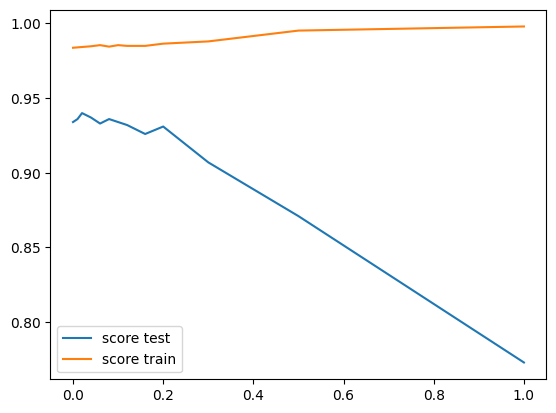

In [39]:
import matplotlib.pyplot as plt 

plt.figure()
plt.plot([0,0.01,0.02,0.04,0.06,0.08,0.1,0.12,0.16,0.2,0.3,0.5,1],[i[0] for i in test],label="score test")
plt.plot([0,0.01,0.02,0.04,0.06,0.08,0.1,0.12,0.16,0.2,0.3,0.5,1],[i[0] for i in train],label = "score train")
plt.legend()
plt.show()

In [ ]:
i = np.argmax([i[0] for i in test])
j = np.argmin([i[1] for i in test])
print(i,j)
test[i][0],test[j][1]



2 9


(np.float64(0.9399999999999997), np.float64(0.03584619420460217))

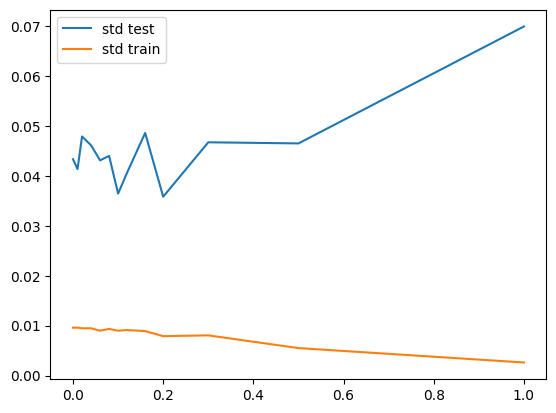

In [40]:
plt.figure()
plt.plot([0,0.01,0.02,0.04,0.06,0.08,0.1,0.12,0.16,0.2,0.3,0.5,1],[i[1] for i in test],label="std test")
plt.plot([0,0.01,0.02,0.04,0.06,0.08,0.1,0.12,0.16,0.2,0.3,0.5,1],[i[1] for i in train],label = "std train")
plt.legend()
plt.show()

In [6]:
grid_search = GridSearchCV(pipeline,param_grid=param_grid,cv=5,verbose=3,return_train_score=True)
grid_search.fit(X,y["Category"])

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=100, dataAugment__noise_factor=0.0;, score=(train=0.988, test=0.850) total time=   0.8s
[CV 2/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=100, dataAugment__noise_factor=0.0;, score=(train=0.988, test=0.900) total time=   0.3s
[CV 3/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=100, dataAugment__noise_factor=0.0;, score=(train=0.988, test=1.000) total time=   0.3s
[CV 4/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=100, dataAugment__noise_factor=0.0;, s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('normaliser', MinMaxScaler()),
                                       ('dataAugment', GaussianNoiseInjector()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [5],
                         'classifier__max_features': ['sqrt'],
                         'classifier__min_samples_leaf': [2],
                         'classifier__min_samples_split': [2],
                         'classifier__n_estimators': [100, 300, 500],
                         'dataAugment__noise_factor': [0.0, 0.01, 0.03, 0.05,
                                                       0.08, 0.1, 0.15, 0.2]},
             return_train_score=True, verbose=3)

The model is fitted and now we want to properly evaluate the results. 
We select only the result from the best_params founded by the search. (Reminder that the best params are the one that provided the best mean validation score)

In [7]:
best_params = grid_search.best_params_
print(best_params)
results = grid_search.cv_results_

# Only keep the cv result for the best paramaters.
best_idx = results['params'].index(best_params)

mean_train_score = results['mean_train_score'][best_idx]
mean_valid_score = results['mean_test_score'][best_idx]
std_train_score = results['std_train_score'][best_idx]
std_valid_score = results['std_test_score'][best_idx]
print(mean_valid_score,std_valid_score)
print(mean_train_score,std_train_score)

{'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'dataAugment__noise_factor': 0.05}
0.96 0.058309518948453015
0.9875 0.007905694150420955


In [21]:
# CONSTRUCTION DE LA PIPELINE D"INFERENCE QUI NE FAIT PLUS DE DATA AUG
best_pipeline = grid_search.best_estimator_
inference_steps = [
    (name, step)
    for name, step in best_pipeline.steps
    if name != "dataAugment"
]
inf_pipeline = Pipeline(inference_steps)
print(inf_pipeline.get_params())

{'memory': None, 'steps': [('normaliser', MinMaxScaler()), ('classifier', RandomForestClassifier(max_depth=5, min_samples_leaf=2))], 'transform_input': None, 'verbose': False, 'normaliser': MinMaxScaler(), 'classifier': RandomForestClassifier(max_depth=5, min_samples_leaf=2), 'normaliser__clip': False, 'normaliser__copy': True, 'normaliser__feature_range': (0, 1), 'classifier__bootstrap': True, 'classifier__ccp_alpha': 0.0, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': None, 'classifier__max_samples': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__monotonic_cst': None, 'classifier__n_estimators': 100, 'classifier__n_jobs': None, 'classifier__oob_score': False, 'classifier__random_state': None, 'classifier__verbose': 0, 'classifier__warm_start': 

In [19]:
from sklearn.metrics import confusion_matrix,accuracy_score

y_pred = inf_pipeline.predict(X)
cm = confusion_matrix(y,y_pred)
acc = accuracy_score(y,y_pred)
print(acc)
print(cm)

0.99
[[20  0  0  0  0]
 [ 0 19  1  0  0]
 [ 0  0 20  0  0]
 [ 0  0  0 20  0]
 [ 0  0  0  0 20]]


In [25]:
proba = inf_pipeline.predict_proba(X)
L = [0,0,0,0,0]
for x in proba : 
    a= 0
    index = []
    for ind,i in enumerate(x) :
        if i > 0.3 : 
            a+=1
            index.append(ind)
    if a >=2 : 
        for j in index : 
            L[j] +=1  
print(proba)  
print(L)

[[2.50000000e-02 6.00000000e-03 0.00000000e+00 9.67000000e-01
  2.00000000e-03]
 [2.66666667e-02 5.00000000e-03 0.00000000e+00 3.00000000e-02
  9.38333333e-01]
 [0.00000000e+00 8.86503890e-01 1.13496110e-01 0.00000000e+00
  0.00000000e+00]
 [5.41666667e-02 1.66666667e-02 2.00000000e-02 0.00000000e+00
  9.09166667e-01]
 [5.00000000e-03 0.00000000e+00 0.00000000e+00 5.00000000e-03
  9.90000000e-01]
 [0.00000000e+00 2.03303030e-01 7.76969697e-01 6.81818182e-03
  1.29090909e-02]
 [5.00000000e-03 6.84395155e-01 3.05377572e-01 4.31818182e-03
  9.09090909e-04]
 [8.39500000e-01 2.95652174e-02 2.21014493e-02 1.00000000e-02
  9.88333333e-02]
 [1.00000000e-02 2.59864551e-01 6.48135449e-01 1.50000000e-02
  6.70000000e-02]
 [0.00000000e+00 9.00977574e-01 9.90224263e-02 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.00000000e-02 1.50000000e-02 0.00000000e+00
  9.75000000e-01]
 [1.10833333e-01 1.65969697e-01 6.39696970e-02 6.10818182e-01
  4.84090909e-02]
 [0.00000000e+00 1.00000000e-02 1.500000

In [ ]:
submission_name = "submission_6.csv"
submission_dataframe = pd.DataFrame(columns=["Id","Category"])
submission_dataframe["Id"] = X_test.index + 101
y_test_pred = inf_pipeline.predict(X_test)
submission_dataframe["Category"] = y_test_pred
submission_dataframe.to_csv(os.path.join(os.getcwd(),submission_name),index=False)
print("file saved")

file saved


In [68]:
print(results)

{'mean_fit_time': array([0.52439227, 0.33216739, 0.78185863, 1.06228399, 0.24847083,
       0.72724605, 0.50502634, 0.24399576, 0.85253258, 0.49005198,
       0.25871849, 1.15344124, 0.64535775, 0.28158813, 1.00862079,
       0.56898079, 0.23929706, 1.37065978, 0.62069354, 0.34187608,
       1.10745449, 0.51894016, 0.24351225, 0.62190976, 0.40457969,
       0.20795636, 0.66053028, 0.51950731, 0.21689811, 0.60886497,
       0.40733318, 0.2061132 , 0.62930079, 0.42065396, 0.20357862,
       0.61763678, 0.40338464, 0.20188718, 0.60143943, 0.39730244,
       0.20660067, 0.60029545, 0.3993855 , 0.21384039, 0.57955394,
       0.40085502, 0.20364676, 0.61233377, 0.4103231 , 0.20309544,
       0.60828619, 0.40646539, 0.2089272 , 0.61386843, 0.48383355,
       0.47594175, 0.69458203, 0.45496426, 0.26892204, 0.67864127,
       0.64882388, 0.40613494, 1.13338962, 0.50134783, 0.25873475,
       0.81367412, 0.5574779 , 0.25267282, 0.73289986, 0.46612849,
       0.24230151, 0.85123119, 0.49586768, 0

In [10]:
f_importance = grid_search.best_estimator_.named_steps["classifier"].feature_importances_
f_name = grid_search.best_estimator_.named_steps["normaliser"].get_feature_names_out()
feature_importance = pd.DataFrame({
    "feature": f_name,
    "importance": f_importance
})
feature_importance.sort_values("importance", ascending=False, inplace=True)
print(feature_importance)

                          feature  importance
32  ES_LV_volume_div_ED_LV_volume    0.058551
16  ED_LV_volume_div_ES_LV_volume    0.052516
10  ED_RV_volume_div_ES_LV_volume    0.045131
29  ES_RV_volume_div_ES_MY_volume    0.043135
21  ED_MY_volume_div_ES_RV_volume    0.042172
27  ES_RV_volume_div_ED_MY_volume    0.039001
33  ES_LV_volume_div_ED_MY_volume    0.038312
7   ED_RV_volume_div_ED_LV_volume    0.037505
4                    ES_LV_volume    0.037015
26  ES_RV_volume_div_ED_LV_volume    0.036368
35  ES_LV_volume_div_ES_MY_volume    0.032368
31  ES_LV_volume_div_ED_RV_volume    0.031462
22  ED_MY_volume_div_ES_LV_volume    0.031429
28  ES_RV_volume_div_ES_LV_volume    0.031416
47  body_surface_div_ES_LV_volume    0.031327
40  ES_MY_volume_div_ES_RV_volume    0.030297
41  ES_MY_volume_div_ES_LV_volume    0.028464
17  ED_LV_volume_div_ES_MY_volume    0.024806
9   ED_RV_volume_div_ES_RV_volume    0.024164
20  ED_MY_volume_div_ED_LV_volume    0.022924
15  ED_LV_volume_div_ES_RV_volume 

Below two cells to save the results : the model and the description of the method used.

In [12]:
description = "Data augmentation cleaned + MinmaxScaler + Randomforest with Gridsearch." 
other_params = "The features are just the volume of each segmentation + body surface + all the possible ratios."
name_folder = "RF_data_aug_noise_pipeline"
feature_used = f_name
informationDict = {
    "description": description,
    "model parameters" : best_params,
    "features used" : feature_used,
    "mean test accuracy with best params" : mean_valid_score ,
    "std  test with best params" : std_valid_score,
    "mean train accuracy with best params" : mean_train_score,
    "std train best params" : std_train_score,
    "other parms" : other_params,
    
}

In [13]:
import joblib
from datetime import datetime
import os

# Create a timestamp
currentDateTime = datetime.now()

# Get the base directory (current directory)
BASE_DIR = os.getcwd()
print(f"BASE_DIR: {BASE_DIR}")
RESULT_DIR = os.path.join(BASE_DIR,"output")
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)
    print(f"Directory created: {RESULT_DIR}")

# Create a folder named 'pipeline_<timestamp>' in the current directory
dir_name = name_folder
dir_path = os.path.join(RESULT_DIR, dir_name)

# If the directory doesn't exist, create it
if not os.path.exists(dir_path):
    os.mkdir(dir_path)
    print(f"Directory created: {dir_path}")

# Save the model inside this new folder
model_filename = 'pipeline_' + currentDateTime.strftime("%H-%M-%S") + '.pkl'
model_path = os.path.join(dir_path, model_filename)

# This is where you'd have your model defined
joblib.dump(grid_search, model_path)
print(f"Model saved to: {model_path}")


# Saving feature importance : 
feature_importance_filename ='pipeline_' + currentDateTime.strftime("%H-%M-%S") + '.csv' 
feature_importance_dir = os.path.join(dir_path,feature_importance_filename)
feature_importance.to_csv(feature_importance_dir)


# SAVING Description 
dict_filename = 'params.txt'
dict_path = os.path.join(dir_path, dict_filename)

with open(dict_path, 'w') as f:
    for key, val in informationDict.items():
        f.write(f"{key} : {val}\n")
print(f"Information about the model saved to: {dict_path}")


BASE_DIR: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction
Directory created: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/output/RF_data_aug_noise_pipeline
Model saved to: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/output/RF_data_aug_noise_pipeline/pipeline_20-05-46.pkl
Information about the model saved to: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/output/RF_data_aug_noise_pipeline/params.txt
